<font color="red" size=3.4> 
    Ce notebook a été réalisé par P. Bianchi et K. Elgui, Télécom ParisTech. Son usage est privé ne doit pas dépasser le cadre du cours "IA317 Large scale machine learning". En particulier, nous vous demandons de ne pas rendre
    de code accessible via github ou autre moyen de partage.
    </font> 

<font color="red">
Effectuer les imports nécessaires (numpy, pandas, etc.) ou le faire au fil de vos besoins.
</font>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings 
warnings.filterwarnings(action='ignore')
%matplotlib inline

# Les données
La signification des features est fournie ici https://www.kaggle.com/c/avazu-ctr-prediction/data  
<font color="red">
Charger les données dans une dataframe et visualiser les premières lignes.</font>

In [32]:
df = pd.read_csv('../data/train-1000000')

<font color="red">
Quelle est la fréquence des 'clicks' dans la base de donnée ? </font>

In [3]:
print("La frequence des 'clicks': " + str(df['click'].astype('int64').mean()))

La frequence des 'clicks': 0.169971


On est donc en présence d'un jeu de données déséquilibré. La classe des 'clics' constitue moins d'un cinquième de toute la base de données. On sait d'emblée qu'un classifieur prédisant toujours 'non-clic' aura d'assez bonnes performances en termes de taux d'erreur (de l'ordre de 0.17). La courbe ROC ou le lift seront de meilleures métriques de performance.
<p>
<font color="red">
Quelles sont les features catégorielles ? Combien de valeurs distinctes prennent-elles chacune ?</font>

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 24 columns):
id                  1000000 non-null float64
click               1000000 non-null int64
hour                1000000 non-null int64
C1                  1000000 non-null int64
banner_pos          1000000 non-null int64
site_id             1000000 non-null object
site_domain         1000000 non-null object
site_category       1000000 non-null object
app_id              1000000 non-null object
app_domain          1000000 non-null object
app_category        1000000 non-null object
device_id           1000000 non-null object
device_ip           1000000 non-null object
device_model        1000000 non-null object
device_type         1000000 non-null int64
device_conn_type    1000000 non-null int64
C14                 1000000 non-null int64
C15                 1000000 non-null int64
C16                 1000000 non-null int64
C17                 1000000 non-null int64
C18              

In [5]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3.983206e+18,0,14102915,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,...,1,2,4687,320,50,423,2,39,100148,32
1,7.756884e+18,0,14103007,1002,0,cb809abf,74acf31a,50e219e0,ecad2386,7801e8d9,...,0,0,17894,320,50,2039,2,39,100077,32
2,6.941774e+17,0,14102711,1005,0,85f751fd,c4e18dd6,50e219e0,e9739828,df32afa9,...,1,0,22684,320,50,2619,1,163,100055,71
3,2.664154e+18,1,14102903,1005,0,85f751fd,c4e18dd6,50e219e0,a5184c22,b8d325c3,...,1,0,23222,320,50,2676,0,35,100176,221
4,1.480510e+19,0,14102902,1005,1,791b5571,fd13bc73,f028772b,ecad2386,7801e8d9,...,1,0,8330,320,50,761,3,175,100081,23


In [6]:
valeurs_distinctes = []
for item in df.columns:
    valeurs_distinctes.append(len(df.groupby(item)))
dict_valeurs_distinctes = {}
for i in np.arange(0,len(df.columns)):
    dict_valeurs_distinctes[df.columns[i]] = valeurs_distinctes[i]
dict_valeurs_distinctes

{'C1': 7,
 'C14': 2243,
 'C15': 8,
 'C16': 9,
 'C17': 420,
 'C18': 4,
 'C19': 66,
 'C20': 163,
 'C21': 60,
 'app_category': 26,
 'app_domain': 198,
 'app_id': 3157,
 'banner_pos': 7,
 'click': 2,
 'device_conn_type': 4,
 'device_id': 150501,
 'device_ip': 555248,
 'device_model': 5168,
 'device_type': 5,
 'hour': 240,
 'id': 1000000,
 'site_category': 22,
 'site_domain': 2871,
 'site_id': 2651}

C1,C15,C16,C17,C18,C19,C20,C21,app_category,banner_pos,click,device_conn_type,device_type,hour,site_category are category features.

<font color="red">
Si on devait procéder à un encodage en dummies de toutes les variables catégorielles, quelle serait la dimension du modèle ?
</font>

In [7]:
sum(valeurs_distinctes)

1723080

There will be 1723080 dimensions 

<font color="red">
Analyser la colonne 'hour' : quel est le format utilisé ? Comment peut on transformer/simplifier cette feature ?</font>

Feature 'hour' includes year,month,day,hour information.We can use datasplit to split 'hour' feature into 'weekday' and 'hour' features. 

<font color="red">
Tester le script suivant.</font>

In [3]:
def datesplit(originalDate):
    originalDate = str(originalDate)
    year = int(originalDate[0:2])
    month = int(originalDate[2:4])
    day = int(originalDate[4:6])
    hour = int(originalDate[6:8])
    return datetime.datetime(year,month,day,hour)

# Exemple :
datesplit(14102915).weekday(), datesplit(14102915).hour  

(2, 15)

<font color="red">
Avec la méthode "apply", créer une colonne 'weekday' pour le jour de la semaine, et remplacer la colonne 'hour' par l'heure.</font>

In [4]:
df['weekday'] = df['hour'].apply(lambda x:datesplit(x).weekday())
df['hour'] = df['hour'].apply(lambda x:datesplit(x).hour)

<font color="red">
Avec la méthode "groupby", visualiser l'influence de l'heure et du jour sur les clicks.</font>

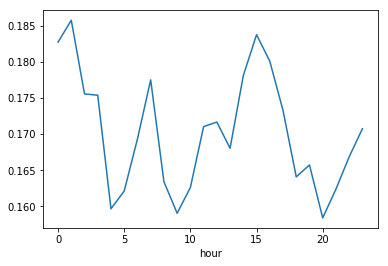

In [11]:
hour = df.groupby('hour')['click']
hour.mean().plot()

Commencer par comprendre les features ayant peu de modalités : 
'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.

<font color="red">
Inspecter par exemple les colonnes 'C15' (dimension de l'annonce) et 'site_category' : visualiser la moyenne des clics.</font>

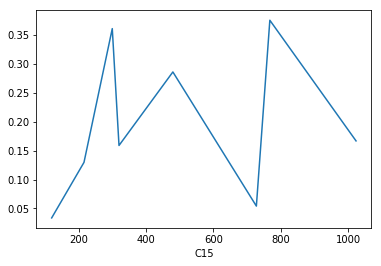

In [12]:
c15 = df.groupby('C15')['click']
c15.mean().plot()

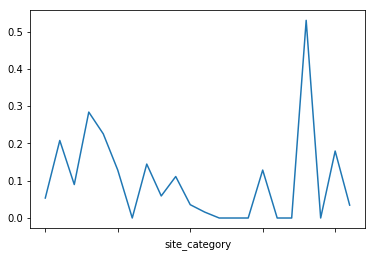

In [13]:
site_category = df.groupby('site_category')['click']
site_category.mean().plot()

<font color="red">
Certaines catégories de site ont un taux de click nul. Pourquoi ? Vérifier en affichant le count de chaque modalité.</font>

In [14]:
site_category.mean()[site_category.mean()==0.0]

site_category
5378d028    0.0
9ccfa2ea    0.0
a818d37a    0.0
bcf865d9    0.0
c706e647    0.0
da34532e    0.0
e787de0e    0.0
Name: click, dtype: float64

Site_category of 5378d028, 9ccfa2ea, a818d37a, bcf865d9, c706e647,da34532e, e787de0e have mull avergae click. However there are still a few clicks in those site_category.

In [15]:
category = site_category.mean()[site_category.mean()==0.0]
site_category.size()[category.index]

site_category
5378d028    11
9ccfa2ea     5
a818d37a    81
bcf865d9    16
c706e647     1
da34532e     1
e787de0e    28
Name: click, dtype: int64

Il est pratique visualiser les deux colonnes conjointement :

In [16]:
col = 'C15'
a = pd.DataFrame([df.groupby(col)['click'].mean(),df.groupby(col)['click'].count()]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count',ascending=False)

,mean,count
C15,,
320,0.158767,933088.0
300,0.360537,57492.0
216,0.129612,7345.0
728,0.054144,1810.0
120,0.033708,89.0
1024,0.166667,72.0
480,0.285714,56.0
768,0.375000,48.0


In [17]:
col = 'site_category'
a = pd.DataFrame([df.groupby(col)['click'].mean(),df.groupby(col)['click'].count()]).transpose()
a.columns = ['mean', 'count']
a.sort_values(by='count',ascending=False)

,mean,count
site_category,,
50e219e0,0.128597,408921.0
f028772b,0.179719,313339.0
28905ebd,0.208076,182020.0
3e814130,0.284245,75667.0
f66779e6,0.034564,6365.0
75fa27f6,0.111305,4007.0
335d28a8,0.089824,3351.0
76b2941d,0.035756,2573.0
c0dd3be3,0.128655,1026.0


<font color="red">
Diviser le jeu de données en un train et un test set</font>

In [18]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop(columns=['click']), df['click'], test_size=0.1,random_state=42)

# Premier travail sur un nombre réduit de features
<p>
<font color="red">
Dans une nouvelle dataframe X1, extraire les colonnes : 'hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21'.
</font>

In [19]:
some_columns = ['hour', 'weekday', 'C1', 'banner_pos', 'site_category', 'app_category', 
                'device_type', 'device_conn_type', 'C15', 'C16', 'C18', 'C21']
X1 = df[some_columns]

<font color="red"> Créer deux nouvelles matrices Xtrain_oh et Xtest_oh contenant les données de train et de test, transformées en dummies à l'aide du onehot-encoder de sklearn.

Quel est le type de Xtrain_oh ?
</font>

In [20]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
le = LabelEncoder()
enc = OneHotEncoder()
site_category = X1[['site_category']].apply(le.fit_transform)
site_category = pd.DataFrame(enc.fit_transform(site_category).toarray(), columns=le.classes_)
app_category = X1[['app_category']].apply(le.fit_transform)
app_category = pd.DataFrame(enc.fit_transform(app_category).toarray(), columns=le.classes_)
X = pd.concat([X1.drop(['site_category', 'app_category'], 1), site_category, app_category], axis=1)

In [21]:
Xtrain_oh, Xtest_oh, ytrain_oh, ytest_oh = train_test_split(X,df['click'],test_size=0.1,random_state=42)

In [22]:
type(Xtrain_oh)

pandas.core.frame.DataFrame

<font color="red">
Quel est le nouveau nombre de colonnes ?</font>

In [23]:
Xtrain_oh.shape[1]

58

There are 58 columns in the new dataframe

<font color="red">
Visualiser la première ligne de la matrice de design obtenue (la convertir en numpy.array avec la méthode .toarray())</font>

In [24]:
np.array(Xtrain_oh)[0]

array([2.100e+01, 3.000e+00, 1.005e+03, 1.000e+00, 1.000e+00, 2.000e+00,
       3.200e+02, 5.000e+01, 2.000e+00, 2.300e+01, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00])

<font color="red">
Fitter un modèle de régression logistique aux données d'apprentissage.</font>

### Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(Xtrain_oh, ytrain_oh)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<font color="red">
À l'aide des méthodes predict et predict_proba, afficher les décisions dures et les décisions douces obtenues sur les données de test.</font>

In [26]:
hard = classifier.predict(Xtest_oh)
soft = classifier.predict_proba(Xtest_oh)[:,1]
print(hard)
print(soft)

[0 0 0 ... 0 0 0]
[0.04381742 0.17639956 0.22814061 ... 0.41934316 0.22433483 0.25968078]


<font color="red">
Evaluer la probabilité d'erreur et commenter (on pourra comparer cette erreur avec celle d'un classifieur identiquement nul).</font>

In [27]:
from sklearn.metrics import confusion_matrix
confusion_matrix_ = confusion_matrix(ytest_oh, hard)
confusion_matrix_

array([[82851,    76],
       [17045,    28]], dtype=int64)

In [28]:
fp = confusion_matrix_[1][0]
fn = confusion_matrix_[0][1]
print(fp/confusion_matrix_.sum(), fn/confusion_matrix_.sum())

0.17045 0.00076


The false positive rate is 0.17, the false negative rate is 0.00076. The frequent of positive in the dataset is 0.169, so this regression is falsly predict many '0' as '1'

<font color="red">
Afficher la courbe ROC et l'aire sous la courbe ROC. Calculer la log-loss</font>

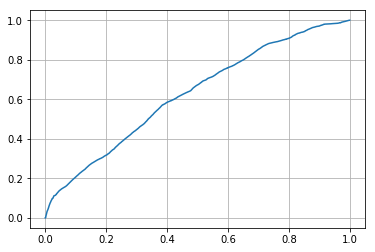

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
pfa, power, _ = roc_curve(ytest_oh, soft)
plt.plot(pfa, power)
plt.grid()

In [30]:
roc_auc_score(ytest_oh, soft)

0.6257764241325963

In [31]:
log_loss(ytest_oh, soft)

0.4397498662123666

### Random Forest

Nous renvoyons à l'aide sklearn http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html.
Dans un premier temps, nous proposons de fitter le RFClassifier par défaut de sklearn. 
Dans la suite, nous allons chercher à optimiser ses hyperparamètres afin de gagner en performance.
 
<font color="red">
Entrainer un RF-classifier sur le modèle restreint. Utiliser dans un premier temps des arbres profonds en fixant le nombre d'exemples par feuilles à 1.
    
On pourra fixer le paramètres n_jobs à -1 pour paralléliser la construction de la forêt. On évaluera également avec %%time le temps de calcul.
</font> 

In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier
RFClassifier = RandomForestClassifier(min_samples_leaf=1, n_jobs=-1)
RFClassifier.fit(Xtrain_oh, ytrain_oh)

Wall time: 12.6 s


<font color="red">Afficher les hyperparamètres utilisés par votre random forest (utiliser "print").</font>

In [33]:
print(RFClassifier)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


<font color="red">Calculer la valeur de l'aire sous la courbe ROC et la log-loss.</font>

In [34]:
hard = RFClassifier.predict(Xtest_oh)
soft = RFClassifier.predict_proba(Xtest_oh)[:,1]

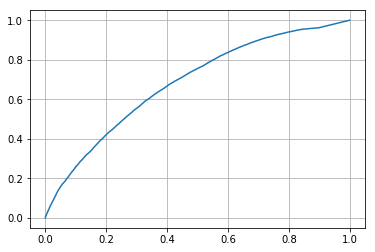

In [35]:
pfa, power, _ = roc_curve(ytest_oh, soft)
plt.plot(pfa,power)
plt.grid()

In [36]:
log_loss(ytest_oh, soft)

0.6400556187427918

<font color="red">Entrainer un RF-classifieur en limitant cette fois la profondeur des arbres. Par exemple, on pourra fixer le nombre minimal d'exemples par feuille à 20.

Afficher l'AUC et la log-loss</font>

In [37]:
RFClassifier_ = RandomForestClassifier(min_samples_leaf=20, n_jobs=-1)
RFClassifier_.fit(Xtrain_oh, ytrain_oh)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [38]:
hard = RFClassifier_.predict(Xtest_oh)
soft = RFClassifier_.predict_proba(Xtest_oh)[:,1]
roc_auc_score(ytest_oh, soft)

0.6940722198833889

In [39]:
log_loss(ytest_oh, soft)

0.421055513482563

<font color="red">Expliquer l'influence de la profondeur des arbres.
<br>
Tracer les courbes ROC pour chaque modèle.</font>

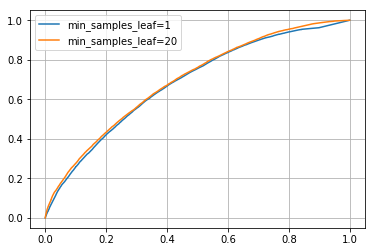

In [40]:
pfa_, power_, _ = roc_curve(ytest_oh, soft)
plt.plot(pfa, power, label='min_samples_leaf=1')
plt.plot(pfa_, power_, label='min_samples_leaf=20')
plt.grid()
plt.legend()

Reduce the depth of the tree can reduce the amount of calculation, and can prevent overfitting

#### Choix des hyper-paramètres
Nous vous proposons d'utiliser la librairie hyperopt (https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf) pour optimiser les hyper-paramètres de Random Forest. Vous avez aussi la possibilité de lancer, par exemple, une recherche exhaustive sur une grille à l'aide de la méthode sklearn sklearn.model_selection.GridSearchCV. 
<font color="red">
- Pour des raisons de temps de calcul, nous n'optimiserons ici que le paramètre "min_samples_leaf". Sur quels autres paramètres aurait-on pu lancer l'optimisation?
<br>
- Compléter le code ci-dessous afin d'évaluer le meilleur hyperparamètre en termes de log-loss.
</font>

In [41]:
%%time
import hyperopt
from hyperopt import fmin, tpe, rand, hp, Trials, STATUS_OK

space = {
    #'test_size': hp.uniform('test_size', .1, .9),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 50, 1),
}

df_result_hyperopt = pd.DataFrame(
    columns=['loss', 'estimators'] + list(space.keys()))

i = 0
Xt, Xv, yt, yv = \
train_test_split(Xtrain_oh, ytrain, test_size=.3, random_state=42)

def objective(space):
    global i
    i += 1
    clf = RandomForestClassifier(max_depth=space['min_samples_leaf'], n_jobs=-1)
    clf.fit(Xt, yt)
    loss = log_loss(yv, clf.predict_proba(Xv)[:,1])
    print("\r iteration: {} \t {}  >>> LOSS: {}".format(i, space, loss))
    df_result_hyperopt.loc[i, ['loss',  'estimators'] + list(space.keys())] = \
        [loss,  clf] + list(space.values())
    return {'loss': loss, 'status': STATUS_OK}

trials = Trials()

best = fmin(fn=objective, space=space, algo=tpe.suggest,
            max_evals=10, trials=trials)


 iteration: 1 	 {'min_samples_leaf': 28.0}  >>> LOSS: 0.5718009606403202
 iteration: 2 	 {'min_samples_leaf': 47.0}  >>> LOSS: 0.6949648818774252
 iteration: 3 	 {'min_samples_leaf': 46.0}  >>> LOSS: 0.6875679246994368
 iteration: 4 	 {'min_samples_leaf': 33.0}  >>> LOSS: 0.6482381128258222
 iteration: 5 	 {'min_samples_leaf': 21.0}  >>> LOSS: 0.43298664972159284
 iteration: 6 	 {'min_samples_leaf': 8.0}  >>> LOSS: 0.42869905975366696
 iteration: 7 	 {'min_samples_leaf': 32.0}  >>> LOSS: 0.610209991481463
 iteration: 8 	 {'min_samples_leaf': 38.0}  >>> LOSS: 0.6824531913408591
 iteration: 9 	 {'min_samples_leaf': 48.0}  >>> LOSS: 0.6955121970556212
 iteration: 10 	 {'min_samples_leaf': 48.0}  >>> LOSS: 0.6930370366846293
Wall time: 1min 26s


<font color="red">Afficher la courbe des log-loss obtenues en fonction de l'hyper-paramètre. A-t-on exploré tous les points de la grille ?</font>

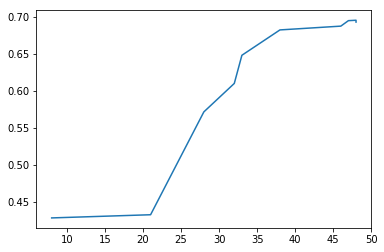

In [42]:
df_log_loss = df_result_hyperopt.sort_values('min_samples_leaf')
plt.plot(df_log_loss['min_samples_leaf'], df_log_loss['loss'])

Facultatif : Si le temps le permet, on pourra comparer hyperopt avec la méthode GridSearchCV de sklearn (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)

In [43]:
#%%time
#from sklearn.model_selection import GridSearchCV
#parameters = {'min_samples_leaf': np.arange(2, 50)}
#clf = RandomForestClassifier(n_jobs=-1)
#rfc_gs = GridSearchCV(clf, parameters)
#rfc_gs.fit(Xt, yt)

#### Courbe Lift

Une autre façon de visualiser le résultat de la classification est le lift.  
Chaque seuil possible permet d'isoler un segment de la population testée (ceux qui ont une probabilité de survie supérieure au seuil). Le lift de ce segment est le rapport entre le taux de survie calculé sur ce segment, et le taux de survie global.

<font color="red">
Importer la fonction plot_lift de utils.py, et afficher la courbe de lift.  
Quel est le lift du premier quart de la population identifié par le test ?</font>

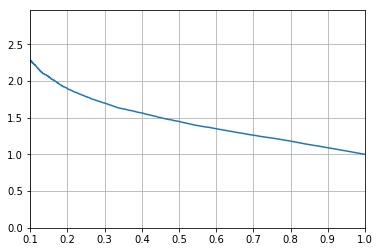

In [44]:
from utils import plotlift
plotlift(ytest_oh, soft)

On obtient un lift égal à un peu moins de deux pour environ 20% de la population (~1.75). C'est à dire qu'on a identifié un segment de la population pour lequel la probabilité de clic est (environ) deux fois supérieure à la population globale.

# Modèle complet
On considère l'exemple de la colonne 'site_id'
<br>
<font color="red">
- Calculer pour chaque modalité, le nombre d'occurrence dans la base de données et la moyenne des clics pour cette modalité.  
- Avec sns.jointplot, représenter l'ensemble des points (count,mean) de chaque modalité.</font>


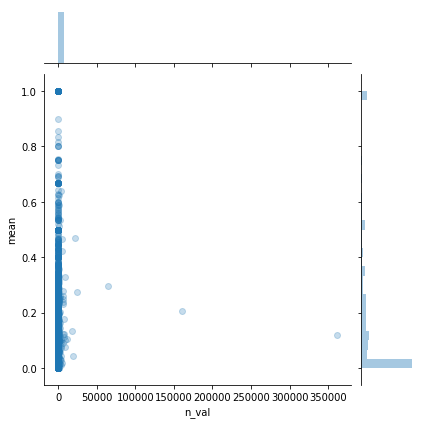

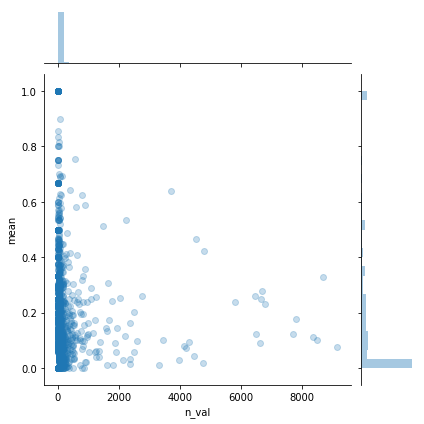

In [45]:
col = 'site_id'
a = pd.concat((df.groupby(col)['click'].mean(), df.groupby(col)['click'].count()), axis=1)
a.columns = ['mean', 'n_val']
sns.jointplot(a['n_val'], a['mean'],alpha=0.25);
thres = 10000
sns.jointplot(a[a['n_val']<thres]['n_val'], a[a['n_val']<thres]['mean'], alpha=0.25);

Plusieurs sites ayant de fortes occurrences dans la base de donnée ont des fréquences de clics très différentes de la moyenne. Il est pertinent de conserver de la colonne 'site_id' au moins les modalités ayant le plus de count.  

<font color="red">
Effectuer le même travail avec la colonne 'device_id'. Que remarquez vous ? A quoi pourrait correspondre le point isolé ?</font>

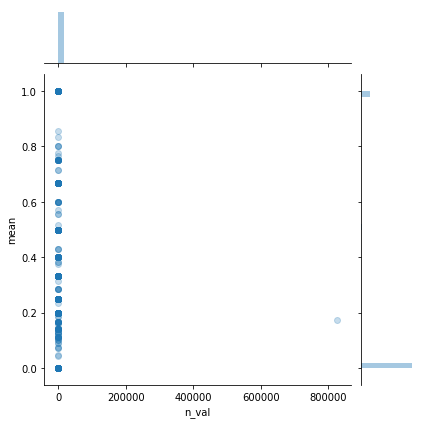

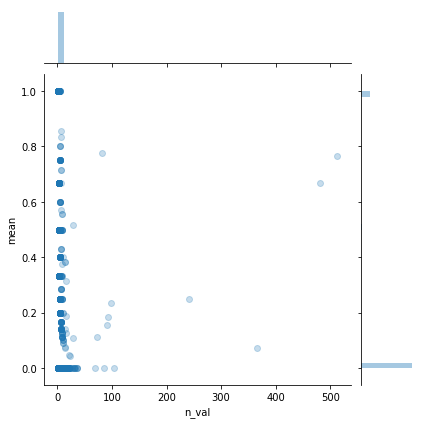

In [46]:
col = 'device_id'
a = pd.concat((df.groupby(col)['click'].mean(), df.groupby(col)['click'].count()), axis=1)
a.columns = ['mean', 'n_val']
thres = 1000
sns.jointplot(a['n_val'],a['mean'],alpha=0.25);
sns.jointplot(a[a['n_val']<thres]['n_val'],a[a['n_val']<thres]['mean'],alpha=0.25);

The distribution of n_val is concentrated

<font color="red">
Dans la colonne df['device_id'], repérer la valeur V correspondant au plus grand nombre count. Créer une nouvelle colonne df['user'] définie de la manière suivante :</font>
$$
\text{user} = \left\{\begin{array}[h]{ll} \text{device_ip + device_model} & \text{si device_id = V}\\ \text{device_id} & \text{sinon.}\end{array}\right.
$$

In [33]:
device_id = df.groupby(by='device_id').size()
V = device_id.sort_values(ascending=False).index[0]
df['user'] = df['device_id']*(df['device_id']!=V)+(df['device_ip']+df['device_model'])*(df['device_id']==V)

<font color="red">
On pourra visualiser de même la similarité entre site_id et site_domain, et fusionner ces deux colonnes.</font>

In [34]:
site_id = df.groupby(by='site_id').size()
V = site_id.sort_values(ascending=False).index[0]
df['user_site'] = df['site_id']*(df['site_id']!=V)+(df['site_domain'])*(df['site_id']==V)

<font color="red">
Effectuons à nouveau le partage train/test à partir de la dataframe df ainsi modifiée 
(test_size = 0.1, random_state = 100)
</font>

In [35]:
from sklearn.model_selection import train_test_split
some_columns = ['id', 'click', 'site_id', 'site_domain', 'device_id', 'device_ip', 'device_model']
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=some_columns), df['click'], test_size = 0.1, random_state = 100)

In [50]:
X_train.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'user_site'],
      dtype='object')

<font color="red">
    Définir un OneHotEncoder.  
Fitter transformer la base de train</font>

In [9]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder(handle_unknown='ignore')
X_train_oh = onehot.fit_transform(X_train)

<font color="red">
Transformer la base de test.  
Si une erreur survient, analyser cette erreur et la résoudre en modifiant le paramètre "handle_unknown" du OneHotEncoder.
</font>

In [10]:
X_test_oh = onehot.transform(X_test)

<font color="red">
Quel est le nombre de features ?</font>

In [54]:
X_train_oh.shape

(900000, 710483)

There are 710483 features.

Le vecteur "n_ones" ci-dessous fournit le nombre de "un" dans chaque colonne de la matrice de train Xtrain_oh.
<br>
<font color="red">
Combien de modalités ont elles été vues plus de 100 fois ? 
</font>

In [58]:
n_ones = X_train_oh.sum(axis=0)
np.sum((n_ones > 100))

1981

There are 1981 columns in which '1' appears more than 100 times

La liste 'cols_to_keep' ci-dessous permet de conserver les indices des modalités vues plus de cent fois.
<font color="red">
(Noter l'usage de la fonction enumerate)
</font>

In [79]:
n_ones_array = np.array(n_ones)[0]
cols_to_keep = []
for i in range(len(n_ones_array)):
    if n_ones_array[i] > 100:
        cols_to_keep.append(i)

<font color="red">En se restreignant aux colonnes de 'cols_to_keep', réentrainer le modèle de régression logistique et comparer les performances.</font>

In [82]:
X_train_oh_keep = X_train_oh[:, cols_to_keep]
X_test_oh_keep = X_test_oh[:, cols_to_keep]

In [86]:
classifier = LogisticRegression()
classifier.fit(X_train_oh_keep, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [87]:
hard = classifier.predict(X_test_oh_keep)
soft = classifier.predict_proba(X_test_oh_keep)[:,1]

In [88]:
confusion_matrix_ = confusion_matrix(y_test, hard)
confusion_matrix_

array([[82161,   838],
       [15782,  1219]], dtype=int64)

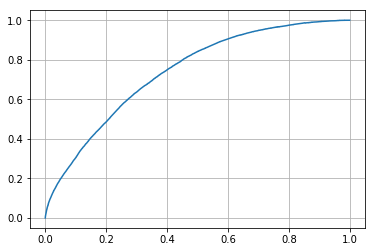

In [89]:
pfa, power, _ = roc_curve(y_test, soft)
plt.plot(pfa, power)
plt.grid()

In [90]:
roc_auc_score(y_test, soft)

0.7394221019707243

In [91]:
log_loss(y_test, soft)

0.4008818137528034

The AUC has increased from 0.62 to 0.73, and the log-loss has decreased form 0.44 to 0.4, so the performance is better.

# Gradient Boosting Decision Trees  
<font color="red">
Importer GradientBoostingClassifier de scikit learn. 
Evaluer les performances, en utilisant une cinquantaine d'estimateurs. Pour comparer :  
- On entrainera le classifieur sur les même colonnes "cols_to_keep" que celles de la régression logistique ;  
- On choisira le learning_rate de manière adequate. </font>

In [92]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(learning_rate=0.8, n_estimators=50, verbose=True)

In [93]:
gb.fit(X_train_oh_keep, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8743            3.55m
         2           0.8646            3.43m
         3           0.8583            3.29m
         4           0.8533            3.23m
         5           0.8501            3.12m
         6           0.8475            3.00m
         7           0.8450            2.96m
         8           0.8432            2.87m
         9           0.8407            2.80m
        10           0.8386            2.73m
        20           0.8287            2.02m
        30           0.8229            1.35m
        40           0.8192           39.60s
        50           0.8158            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=True, warm_start=False)

In [97]:
soft = gb.predict_proba(X_test_oh_keep)[:,1]
log_loss(y_test,soft), roc_auc_score(y_test,soft)

(0.4082174633532699, 0.726908441013325)

<font color="red">
Que fournit l'appel de gb.estimators_ ?
</font>

In [94]:
gb.estimators_[0]

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x0000026E6B9D2750>,
           splitter='best')], dtype=object)

gb.estimators_ gives us parameters of the decision tree regression

On cherche désormais à utiliser le classifieur gb pour générer des features utilisables par la régression logistique.
<font color="red">
Avec la méthode gb.apply du classifieur, générer une transformation leafs_train de la base de train Xtrain_oh[:,cols_to_keep] dont la colonne n correspond au numéro de feuille retourné par l'estimateur n
</font>

In [99]:
leaf_train = gb.apply(X_train_oh_keep).reshape(900000, 50)
leaf_test = gb.apply(X_test_oh_keep).reshape(100000, 50)

<font color="red">
Effectuer l'encodage en dummies de ces nouvelles features.</font>

In [101]:
ohe = OneHotEncoder(handle_unknown='ignore')
leaf_train_oh = ohe.fit_transform(leaf_train)
leaf_test_oh = ohe.transform(leaf_test)

<font color="red">
Avec la fonction hstack, créer une nouvelle matrice de features en concaténant horizontalement les nouvelles features ainsi créées, et les features précédemment utilisées pour la régression logistique. </font>

In [116]:
from scipy.sparse import csr_matrix, hstack
Xtrain_concat = hstack([leaf_train_oh, X_train_oh_keep ])
Xtest_concat = hstack([leaf_test_oh, X_test_oh_keep ])

<font color="red">
Effectuer une régression logistique sur les nouvelles features.</font>

In [118]:
classifier = LogisticRegression()
classifier.fit(Xtrain_concat, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [119]:
hard = classifier.predict(Xtest_concat)
soft = classifier.predict_proba(Xtest_concat)[:,1]

In [120]:
confusion_matrix_ = confusion_matrix(y_test, hard)
confusion_matrix_

array([[82147,   852],
       [15733,  1268]], dtype=int64)

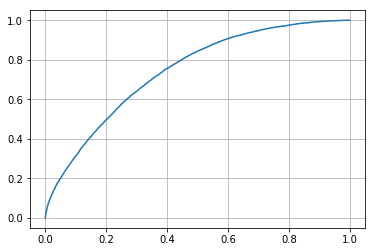

In [121]:
pfa, power, _ = roc_curve(y_test, soft)
plt.plot(pfa, power)
plt.grid()

# XGBoost
<br>
<font color="red">
Importer XGBClassifier du package xgboost.  
Entrainer le classifieur avec le même nombre d'estimateur et le même learning rate que précédemment, et en fixant le paramètre n_jobs=-1.  
Comparer le résultat avec le GradientBoosting de scikit learn (risque et temps de calcul)
</font>

In [122]:
import xgboost
from xgboost import XGBClassifier

In [124]:
%%time
xgb = XGBClassifier(learning_rate=0.8, n_estimators=50, verbose=True, n_jobs=-1)
xgb.fit(X_train_oh_keep, y_train)

Wall time: 14.6 s


XGBoost runs much faster than GradientBoosting

In [126]:
soft = xgb.predict_proba(X_test_oh_keep)[:,1]
log_loss(y_test,soft), roc_auc_score(y_test,soft)

(0.40743721874333916, 0.7261779489592819)

The log_loss and auc_score of GradientBoosting is (0.4082174633532699, 0.726908441013325). The result are equally good, but XGBoost runs much faster.

<font color="red">
Augmenter le nombre d'estimateurs et visualiser l'impact sur les performances (on sera aussi amené à agir sur le learning rate)</font>

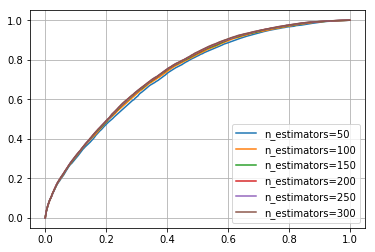

In [134]:
estimators = [50, 100, 150, 200, 250, 300]
loss = []
auc = []
for i in estimators:
    xgb = XGBClassifier(learning_rate=0.8, n_estimators=i, verbose=True, n_jobs=-1)
    xgb.fit(X_train_oh_keep, y_train)
    soft = xgb.predict_proba(X_test_oh_keep)[:,1]
    loss.append(log_loss(y_test,soft))
    auc.append(roc_auc_score(y_test,soft))
    pfa, power, _ = roc_curve(y_test, soft)
    plt.plot(pfa, power, label='n_estimators=' + str(i))
plt.grid()
plt.legend()

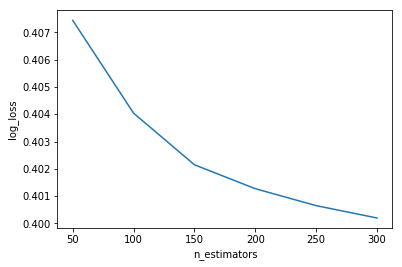

In [135]:
plt.plot(estimators, loss)
plt.xlabel('n_estimators')
plt.ylabel('log_loss')
plt.show()

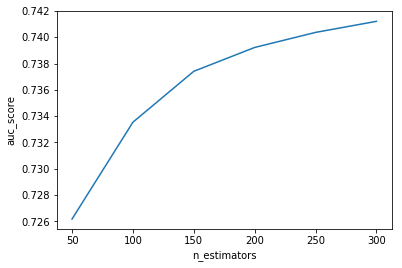

In [136]:
plt.plot(estimators, auc)
plt.xlabel('n_estimators')
plt.ylabel('auc_score')
plt.show()

# Part 2

# Hashing de features et random forest
<br>
Nous repartons des features brutes avant encodage en dummies (Xtrain, Xtest).
<font color="red">
Afficher à nouveau le nombre de modalités uniques par feature dans Xtrain.
</font>

In [12]:
X_train.shape[1]

20

In [13]:
X_train.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'user_site'],
      dtype='object')

On veut définir une transformation qui regroupe les modalités les moins fréquentes au sein d'un même label "isRare".  
Pour cela, nous choisissons de définir notre propre transformer.
<font color="red">
Comprendre les étapes de fit et de transform.
</font>

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class MergeRareTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_names, threshold):
        self.col_names = col_names
        self.threshold = threshold

    def fit(self, X, y=None):

        X = pd.DataFrame(X)
        counts_dict_list = []
        ################## READ THIS #########################
        for i in range(len(self.col_names)):
            
            serie = X[self.col_names[i]].value_counts()  # Série des counts de chaque modalité
            rare_indexes = serie[serie<self.threshold[i]].index  # A quoi correspondent ces indices ?
            frequent_indexes = serie[serie>=self.threshold[i]].index  # A quoi correspondent ces indices ?
            dico = {x:'isRare' for x in rare_indexes}
            dico.update({x: str(x) for x in frequent_indexes})
            counts_dict_list.append(dico)   # Quel est le dictionnaire obtenu ?
            
        ######################################################
            
        self.counts_dict_list_ = counts_dict_list
        return self

    def transform(self, X):

        Xt = pd.DataFrame()
        ################## READ THIS #########################
        for col, count_dict in zip(self.col_names, self.counts_dict_list_):
            Xt[col] = X[col].apply(lambda x:count_dict[x] if x in count_dict else 'isRare')
            # A quoi sert le "else 'isRare'" dans la transformation de la colonne ?
        ######################################################

        return Xt


<font color="red">
Fitter et transformer le train set. On fusionnera toutes les modalités présentes moins de 20 fois dans chaque colonne.  
Transformer le test set.
</font>

In [15]:
mg = MergeRareTransformer(col_names=X_train.columns,threshold=[20] * len(X_train.columns))
mg.fit(X_train)
X_train_mg = mg.transform(X_train)
X_test_mg = mg.transform(X_test)

<font color="red">
En appliquant la méthode .value_counts(), combien d'éléments de la colonne Xtrain_mg['app_domain'] sont désormais labelisés comme "rares" ?
</font>

In [20]:
X_train_mg['app_domain'].value_counts()

7801e8d9    606390
2347f47a    116467
ae637522     41928
5c5a694b     25289
82e27996     16869
d9b5648e     15709
0e8616ad     14784
b9528b13     14284
b8d325c3     11953
aefc06bd      6644
df32afa9      6412
33da2e74      5911
6f7ca2ba      4990
5b9c592b      2448
885c7f3f      1468
5c620f04      1419
45a51db4      1219
b5f3b24a      1093
813f3323       544
0654b444       514
isRare         513
ad63ec9b       388
c6824def       306
15ec7f39       275
a8b0bf20       266
99b4c806       219
828da833       185
448ca2e3       167
f2f777fb       157
43cf4f06       149
47464e95        99
d6feb1a4        95
2b627705        89
1ea19ec4        72
db829551        69
6a0a3a9d        59
18eb4e75        56
0d79ee56        53
9ec164d3        51
e5d5313f        46
b12ff13e        42
27ee373d        36
b408d42a        30
5ac0b939        28
1ed56ded        27
bb6bcbae        27
3feeed1e        26
63f57be0        25
15c23f8e        25
7eec2ab0        24
7a9371fa        21
dcdba109        20
afdf1f54    

513 labels became "isRare"

<font color="red">
Dans la base de train, afficher le nombre de modalité par colonne.</font>

In [21]:
X_train_mg.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'user_site'],
      dtype='object')

Les modalités sont des objets arbitraires du type : 234, 'isRare', etc. Nous allons les transformer en entiers avec le hashing trick.
<font color="red">
Pour comprendre le fonctionnement de la fonction "hash", l'appliquer à une chaîne de caractère quelconque.
</font>

In [44]:
import hashlib
hash('isRare')%1000000

879128

On créée deux nouvelles dataframe Xtrain_ha, Xtest_ha, contenant le résultat du hashing.
<font color="red">
Avec la méthode .apply, transformer itérativement les colonnes en appliquant à chacune le reste de la division euclidienne du hash par 1000000. Exemple : 
</font>
<p>
<center>
2060777048690<font color="red">918393</font>  -->  918393
</center>

In [35]:
X_train_ha = pd.DataFrame()
X_test_ha = pd.DataFrame()
for col in X_train_mg.columns:
    X_train_ha[col] = X_train_mg[col].apply(lambda x: hash(x)%1000000)
    X_test_ha[col] = X_test_mg[col].apply(lambda x: hash(x)%1000000)

<font color="red">
Visualiser le contenu des dataframe obtenues. </font>

In [37]:
X_train_ha.head()

,hour,C1,banner_pos,site_category,app_id,app_domain,app_category,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,weekday,user,user_site
92438,251955,455746,682632,967423,336556,178495,268275,254720,647118,866417,745064,784425,509278,701814,782896,18592,879436,701814,879128,360237
60898,742787,145527,701814,967423,513679,847217,405957,682632,261165,866417,745064,784425,509278,701814,782896,18592,879436,682632,879128,360237
556199,254720,145527,701814,808151,628482,178495,11539,682632,261165,838420,745064,784425,605825,701814,671630,18592,708088,701814,879128,354733
193129,451247,145527,682632,808151,628482,178495,11539,682632,701814,633838,745064,784425,481786,701814,890123,500284,929788,682632,879128,915351
231985,274807,145527,701814,276626,628482,178495,11539,682632,701814,616957,745064,784425,509278,701814,782896,346328,879436,6486,879128,553827


<font color="red">
Entrainer un classifieur random forest, l'entraîner sur Xtrain_ha, et évaluer ses performances sur Xtest_ha.  
On pourra choisir ~1000 estimateurs, min_samples_leaf=20 et verbose=1 pour être tenu au courant de l'avancée des calculs.  
Comment fixer le paramètre n_jobs ?
</font>

In [38]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=20, verbose=True, n_jobs=-1)
rf.fit(X_train_ha, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 10.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
soft = rf.predict_proba(X_test_ha)[:,1]
log_loss(y_test,soft),roc_auc_score(y_test,soft)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    4.1s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    5.3s finished


(0.4012243135236611, 0.7401093068928805)

<font color="red">
Comparer avec les performances de xgboost sur le même modèle.</font>

The score of the xgboost was (0.40743721874333916, 0.7261779489592819). So this hashing way preforms a little bit better than xgboost when n_estimators=50. But as the n_estimators grows to 300, the result was almost as well as here. 

<font color="red">
Afficher la courbe roc et la courbe de lift pour le classifieur obtenu.</font>

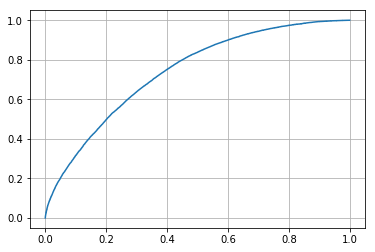

In [40]:
pfa, power, _ = roc_curve(y_test, soft)
plt.plot(pfa, power)
plt.grid()

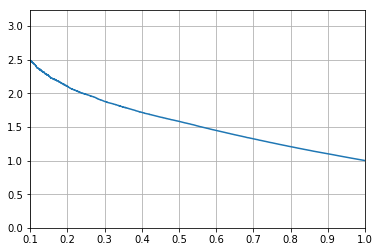

In [41]:
from utils import plotlift
plotlift(y_test, soft)

<font color="red">
Exercice facultatif :  
- utiliser xgboost pour générer des features  
- entrainer un random forest sur les features initiales ET les nouvelles features générées.
</font>

Le hashing produit des colonnes d'entiers ordonnés arbitrairement. On se demande si on peut améliorer les performances en ajoutant d'autre colonnes hashées différemment.
<br>
<font color="red">Ajouter des colonnes de hash en hashant récursivement les précédentes : compléter le code ci-dessous.</font>

In [45]:
Xtrain_haha = pd.DataFrame(X_train_ha).copy()
Xtest_haha = pd.DataFrame(X_test_ha).copy()

n_hash = 3
cols = X_train_ha.columns
for l in range(n_hash):
    for col in cols:
        Xtrain_haha[col+'-hash'] = Xtrain_haha[col].apply(lambda x: hash(x)%1000000)
        Xtest_haha[col+'-hash'] = Xtest_haha[col].apply(lambda x: hash(x)%1000000)
    cols = [col + '-hash' for col in cols]

<font color="red">Evaluer les performances de Random Forest et/ou xgboost</font>

In [47]:
rf = RandomForestClassifier(n_estimators=1000, min_samples_leaf=20, verbose=True, n_jobs=-1)
rf.fit(Xtrain_haha, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed: 20.7min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=True,
            warm_start=False)

In [48]:
soft = rf.predict_proba(Xtest_haha)[:,1]
log_loss(y_test,soft),roc_auc_score(y_test,soft)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    4.2s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    7.6s
[Parallel(n_jobs=8)]: Done 1000 out of 1000 | elapsed:    9.6s finished


(0.399998295279131, 0.7418036500360746)

The performence has improved.

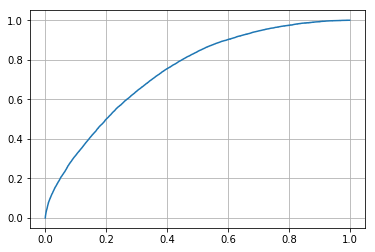

In [49]:
pfa, power, _ = roc_curve(y_test, soft)
plt.plot(pfa, power)
plt.grid()

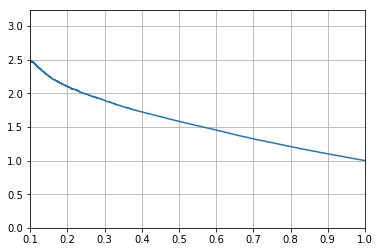

In [50]:
plotlift(y_test, soft)

# Field-aware Factorization Machines
<br>
<font color="red">
Afficher les noms des colonnes de la matrice Xtrain_ha
</font>

In [52]:
X_train_ha.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user', 'user_site'],
      dtype='object')

<font color="red">
Créer une liste de liste de colonnes. La nème sous-liste comporte les noms des colonnes du nème champ.</font>

In [53]:
fields = []
for i in range(len(X_train_ha.columns)):
    fields.append([i, X_train_ha.columns[i]])

<font color="red">
Avec enumerate, générer un dictionnaire qui à chaque nom de colonne associe son champ.</font>

In [91]:
dicFields = { name_col : i  for i,f in enumerate(fields) for name_col in f[1:]}

Pour formatter les données au format LibFFM, nous devons nous assurer que deux colonnes différentes possèdent des modalités différentes. Pour cela, nous ajoutons devant chaque modalité une chaîne de caractère caractéristique de la colonne.
<center>
x --> 'nom de la colonne ' + str(x)
</center>
<br>
<font color="red">Effectuer cette transformation avec la méthode apply</font>

In [69]:
Xtrain_ffm = pd.DataFrame()
Xtest_ffm = pd.DataFrame()
for col in X_train_ha.columns:
    Xtrain_ffm[col] = X_train_ha[col].apply(lambda x: col+str(x))
    Xtest_ffm[col] = X_test_ha[col].apply(lambda x: col+str(x))

Avec np.unique, on créée la liste de toutes les modalités apparaissant dans toutes les colonnes.

In [77]:
allvals = []
allcols_ffm = [col for f in fields for col in f[1:]]  # Toutes les colonnes appartenant à l'un des champ
for col in allcols_ffm:
    allvals.append(np.unique(Xtrain_ffm[col]))
allvals= [val for sublist in allvals for val in sublist]

<font color="red">
En utilisant "enumerate", créer un dictionnaire qui à chaque valeur associe son rang dans la liste allvals.</font>

In [97]:
dicFeat = {val:i for i,val in enumerate(allvals)}

On les dataframe comme suit : 
dans chaque colonne "col", la valeur "x" est remplacée par la chaîne de caractère "f:v:1", où f est le champ associé à la colonne et v est l'indice de la modalité x.
<font color="red">
Inspecter le code ci-dessous.</font>

In [99]:
for col in allcols_ffm:
    f = dicFields[col]
    Xtrain_ffm[col] = Xtrain_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")
    Xtest_ffm[col] = Xtest_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat[x]) if x in dicFeat else "")

<font color="red">Pour les deux dataframe obtenues, concaténer à gauche la colonne de clics ytrain ou ytest correspondante</font>

In [172]:
yXtrain_ffm = pd.concat( [y_train.astype(str), Xtrain_ffm] ,axis=1)
yXtest_ffm = pd.concat( [y_test.astype(str), Xtest_ffm] ,axis=1)

In [213]:
#yXtrain_ffm.to_csv('train.csv', index=False )
#yXtest_ffm.to_csv('test.csv', index=False )

<font color="red">Que produit la commande ci-dessous ?</font>

In [174]:
train_w = yXtrain_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_w = yXtest_ffm.apply(lambda row:' '.join(row.values),axis=1).values

The elements in the dataframe are combined with the split of a space.

<font color="red">Ecrire les dataframe ci-dessus dans un fichier texte</font>

In [175]:
thefile = open('train.txt','w')
for item in train_w:
    thefile.write("%s\n" % item)

# Faire de même pour le test set


In [176]:
thefile2 = open('test.txt','w')
for item in test_w:
    thefile2.write("%s\n" % item)

Pour apprendre le modèle de FFM, on utilise la librairie LibFFM https://www.csie.ntu.edu.tw/~cjlin/libffm/  
Dans le répertoire notebooks/ se trouvent deux exécutables : ffm-train et ffm-predict.  
Dans jupyter notebook, le point d'exclamation ! permet de lancer une commande bash.  
L'usage est le suivant : 

-   `ffm-train'

    usage: ffm-train [options] training_set_file [model_file]

    options:  
    -l <lambda>: set regularization parameter (default 0.00002)  
    -k <factor>: set number of latent factors (default 4)  
    -t <iteration>: set number of iterations (default 15)  
    -r <eta>: set learning rate (default 0.2)  
    -s <nr_threads>: set number of threads (default 1)  
    -p <path>: set path to the validation set  
    --quiet: quiet model (no output)  
    --no-norm: disable instance-wise normalization  
    --auto-stop: stop at the iteration that achieves the best validation loss (must be used with -p)  
<br>
<font color="red">Apprendre le modèle. On pourra :  
- utiliser un paramètre de régularisation de 0.00001  
- utiliser un learning rate de 0.05  
- utiliser de l'ordre de 15 facteurs latents
- effectuer de l'ordre de 30 itérations  
- avec l'option -p, passer en paramètres de validation le ficher de test  
- activer le mode --autostop 
</font> 

In [18]:
!../data/ffm-train -l 0.00001 -r 0.05 -k 15 -t 30 -p test.txt --auto-stop train.txt ffm.model

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (3.1 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (0.3 seconds)
iter   tr_logloss   va_logloss      tr_time
   1      0.41554      0.40620          4.2
   2      0.40450      0.40210          8.3
   3      0.40185      0.40048         12.3
   4      0.40031      0.39942         16.5
   5      0.39921      0.39869         20.6
   6      0.39838      0.39805         24.6
   7      0.39770      0.39753         28.8
   8      0.39710      0.39724         33.0
   9      0.39657      0.39689         37.2
  10      0.39613      0.39671         41.4
  11      0.39570      0.39646         45.5
  12      0.39530      0.39631         49.6
  13      0.39490      0.39614         53.8
  14      0.39457      0.39604         58.0
  15      0.39424      0.3

L'usage de ffm-predict est : ffm-predict nom-fichier-test nom-fichier-modèle fichier-dans-lequel-ecrire-la-prediction  
<font color="red">Effectuer la prédiction.</font>

In [19]:
!../data/ffm-predict train.txt ffm.model ffm.train_prediction
!../data/ffm-predict test.txt ffm.model ffm.test_prediction

logloss = 0.39328
logloss = 0.39585


<font color="red">Calculer la log_loss et l'aire sous la courbe roc.</font>

In [3]:
soft = pd.read_csv('ffm.test_prediction', header=None)[0]

In [9]:
test = pd.read_csv('test.txt', header=None)[0]

In [20]:
y_test = []
for i in range(len(test)):
    y_test.append(int(test[i][0]))
y_test = np.array(y_test)

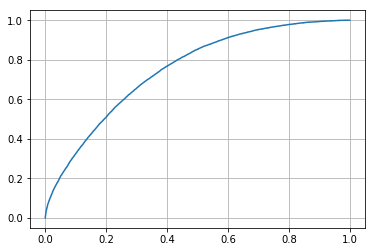

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
pfa, power, _ = roc_curve(y_test, soft)
plt.plot(pfa, power)
plt.grid()

# Blending

<font color="red">
Séparer les données de train Xtrain en deux avec train_test_split.</font>

In [36]:
Xtrain_meth, Xtrain_blend, ytrain_meth, ytrain_blend = train_test_split(X_train,y_train,test_size=0.2)

<font color="red">
Entrainer une régression logistique sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

In [183]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore').fit(X_train)
Xtrain_meth_oh = ohe.transform(Xtrain_meth)
Xtrain_blend_oh = ohe.transform(Xtrain_blend)

In [184]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(Xtrain_meth_oh, ytrain_meth)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [185]:
logreg_score = classifier.predict_proba(Xtrain_blend_oh)[:,1]

<font color="red">
Entrainer un xgboost sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

In [186]:
import xgboost
from xgboost import XGBClassifier
xgb = XGBClassifier(learning_rate=0.8, n_estimators=50, verbose=True, n_jobs=-1)
xgb.fit(Xtrain_meth_oh, ytrain_meth)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.8, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1, verbose=True)

In [188]:
xgb_score = xgb.predict_proba(Xtrain_blend_oh)[:,1]

<font color="red">
Entrainer un random forest sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

In [190]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=50, min_samples_leaf=10, n_jobs=-1)
rf.fit(Xtrain_meth_oh, ytrain_meth)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [191]:
rf_score = rf.predict_proba(Xtrain_blend_oh)[:,1]

<font color="red">
Entrainer un extraTrees sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

In [192]:
from sklearn.ensemble import ExtraTreesClassifier
et = ExtraTreesClassifier(n_estimators=50, min_samples_leaf=10, n_jobs=-1)
et.fit(Xtrain_meth_oh, ytrain_meth)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [193]:
et_score = et.predict_proba(Xtrain_blend_oh)[:,1]

<font color="red">
Entrainer un FFM sur Xtrain_meth, et évaluer ses scores sur Xtrain_blend (conserver dans un vecteur).</font>

In [37]:
fields_meth = []
for i in range (len(Xtrain_meth.columns)):
    fields_meth.append([i, Xtrain_meth.columns[i]])
dicFields_meth = { name_col : i  for i,f in enumerate(fields_meth) for name_col in f[1:]}

In [40]:
Xtrain_meth.columns

Index(['hour', 'C1', 'banner_pos', 'site_category', 'app_id', 'app_domain',
       'app_category', 'device_type', 'device_conn_type', 'C14', 'C15', 'C16',
       'C17', 'C18', 'C19', 'C20', 'C21', 'user', 'user_site'],
      dtype='object')

In [42]:
Xtrain_meth_ffm = pd.DataFrame()
Xtest_meth_ffm = pd.DataFrame()
for col in Xtrain_meth.columns:
    Xtrain_meth_ffm[col] = Xtrain_meth[col].apply(lambda x: col+str(x))
    Xtest_meth_ffm[col] = Xtrain_blend[col].apply(lambda x: col+str(x))

In [43]:
allvals_meth = []
allcols_meth_ffm = [col for f in fields_meth for col in f[1:]] 
for col in allcols_meth_ffm:
    allvals_meth.append(np.unique(Xtrain_meth_ffm[col]))
allvals_meth= [val for sublist in allvals_meth for val in sublist]

In [44]:
dicFeat_meth = {val:i for i,val in enumerate(allvals_meth)}
for col in allcols_meth_ffm:
    f = dicFields_meth[col]
    Xtrain_meth_ffm[col] = Xtrain_meth_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat_meth[x]) if x in dicFeat_meth else "")
    Xtest_meth_ffm[col] = Xtest_meth_ffm[col].apply(lambda x:"{}:{}:1".format(f,dicFeat_meth[x]) if x in dicFeat_meth else "")

In [45]:
yXtrain_meth_ffm = pd.concat( [ytrain_meth.astype(str), Xtrain_meth_ffm] ,axis=1)
yXtest_meth_ffm = pd.concat( [ytrain_blend.astype(str), Xtest_meth_ffm] ,axis=1)

In [46]:
train_meth_w = yXtrain_meth_ffm.apply(lambda row:' '.join(row.values),axis=1).values
test_meth_w = yXtest_meth_ffm.apply(lambda row:' '.join(row.values),axis=1).values

In [47]:
thefile3 = open('train_meth.txt','w')
for item in train_meth_w:
    thefile3.write("%s\n" % item)
thefile4 = open('test_meth.txt','w')
for item in test_meth_w:
    thefile4.write("%s\n" % item)

In [50]:
!../data/ffm-train -l 0.00001 -r 0.05 -k 15 -t 30 -p test_meth.txt --auto-stop train_meth.txt ffm_meth.model

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file (2.5 seconds)
First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file Segmentation fault (core dumped)


<font color="red">
Concaténer tous les scores obtenus sur Xtrain_blend pour former une même matrice de design Zblend.</font>

In [51]:
Zblend = np.zeros((len(ytrain_blend),4))
Zblend[:,0] = logreg_score
Zblend[:,1] = xgb_score
Zblend[:,2] = rf_score
Zblend[:,3] = et_score

<font color="red">
Entrainer une régression logistique sur (Zblend,ytrain_blend).</font>

In [198]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(Zblend, ytrain_blend)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<font color="red">
Evaluer les performances de la méthode sur la base de test.</font>

In [200]:
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
soft = lr.predict_proba(Zblend)[:,1]
log_loss(ytrain_blend,soft),roc_auc_score(ytrain_blend,soft)

(0.40316176675952875, 0.7448819350685599)

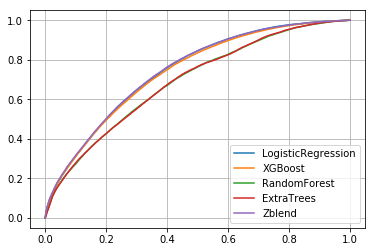

In [218]:
label_name = ['LogisticRegression', 'XGBoost', 'RandomForest', 'ExtraTrees', 'FFM']
for i in range(Zblend.shape[1]):
    pfa, power, _ = roc_curve(ytrain_blend, Zblend[:,i])
    plt.plot(pfa, power, label=label_name[i])
pfa, power, _ = roc_curve(ytrain_blend, soft)
plt.plot(pfa, power, label='Zblend')
plt.grid()
plt.legend()

# Jeu de données complet  
La base complète contient 40.000.000 d'instances. Elle se situe dans le répertoire avazu-large-data-set.zip.  
Afin de vous épargner le temps de prétraitement (labelisation, hashing), les fichiers train_ha.zip et test_ha.zip contiennent les résultats du feature engineering précédent :
- fusion des modalités les moins fréquentes (<20) au sein d'un même label
- hashing des valeurs obtenues.  

In [13]:
train_ha = pd.read_csv('data/train_ha.zip')
test_ha = pd.read_csv('data/test_ha.zip')

<font color="red">Inspecter la première ligne de train_ha. Créer le vecteur ytrain correspondant à la colonne des clics, et la dataframe Xtrain_ha correspondant aux features hashées. Faire de même avec test_ha.</font>

In [3]:
train_ha.loc[0]

click                    1
hour                497260
C1                  979896
banner_pos          711755
site_category       597610
app_id              238638
app_domain           27252
app_category        654350
device_type         711755
device_conn_type    766453
C14                 712124
C15                 723362
C16                 219618
C17                 116136
C18                 145757
C19                 584514
C20                 321746
C21                 814338
weekday             766453
user                699685
site                544630
Name: 0, dtype: int64

In [5]:
Xtrain_ha = train_ha.drop(columns=['click'])
Xtest_ha = test_ha.drop(columns=['click'])

In [14]:
ytrain = train_ha['click']
ytest = test_ha['click']

In [17]:
pd.DataFrame(ytrain).to_csv('ytrain_ha.csv',index=False)
pd.DataFrame(ytest).to_csv('ytest_ha.csv',index=False)

In [18]:
del train_ha, test_ha
import gc
gc.collect()

373

### SGD Classifier

<font color="red">Procéder à l'encodage en dummies</font>

Since the dataset is too large, I can't finish the dummies encode once. So I do this seperatly, by encoding each columns. After that, I merge them

In [2]:
from sklearn.preprocessing import OneHotEncoder
from scipy import sparse

In [7]:
index = 0
for col in Xtrain_ha.columns:
    ohe = OneHotEncoder(handle_unknown='ignore', dtype='uint8')
    matrix_1 = ohe.fit_transform(Xtrain_ha[col].values.reshape(-1,1))
    matrix_2 = ohe.transform(Xtest_ha[col].values.reshape(-1,1))
    filename1 = 'Xtrain_ha_oh_part'+str(index)+'.npz'
    filename2 = 'Xtest_ha_oh_part'+str(index)+'.npz'
    sparse.save_npz(filename1, matrix_1)
    sparse.save_npz(filename2, matrix_2)
    index += 1

In [3]:
import gc
columns_name = ['hour', 'C1', 'banner_pos', 'site_category', 'app_id',
       'app_domain', 'app_category', 'device_type', 'device_conn_type', 'C14',
       'C15', 'C16', 'C17', 'C18', 'C19', 'C20', 'C21', 'weekday', 'user',
       'site']

In [16]:
del Xtrain_ha, Xtest_ha
gc.collect()

462

In [5]:
Xtrain_ha_oh = sparse.load_npz('columns/Xtrain_ha_oh_part0.npz')
#Xtest_ha_oh = sparse.load_npz('Xtest_ha_oh_part0.npz')
index = 1
for col in columns_name[1:]:
    filename1 = 'columns/Xtrain_ha_oh_part'+str(index)+'.npz'
    #filename2 = 'Xtest_ha_oh_part'+str(index)+'.npz'
    temp_train = sparse.load_npz(filename1)
    #temp_test = sparse.load_npz(filename2)
    Xtrain_ha_oh = sparse.hstack([Xtrain_ha_oh, temp_train])
    #Xtest_ha_oh = sparse.hstack([Xtest_ha_oh, temp_test])
    del temp_train#, temp_test
    gc.collect()
    index += 1
sparse.save_npz('Xtrain_ha_oh.npz', Xtrain_ha_oh)
#sparse.save_npz('Xtest_ha_oh.npz', Xtest_ha_oh)

In [8]:
Xtest_ha_oh = sparse.load_npz('columns/Xtest_ha_oh_part0.npz')
index = 1
for col in columns_name[1:]:
    filename2 = 'columns/Xtest_ha_oh_part'+str(index)+'.npz'
    temp_test = sparse.load_npz(filename2)
    Xtest_ha_oh = sparse.hstack([Xtest_ha_oh, temp_test])
    del temp_test
    gc.collect()
    index += 1
sparse.save_npz('Xtest_ha_oh.npz', Xtest_ha_oh)

Those two datasets were stored in the 'Xtrain_ha_oh.npz' and 'Xtest_ha_oh.npz'

<font color="red">Importer SGDClassifier de sklearn.linear_model et effectuer 5 passes sur les données (utiliser les options loss='log' et n_jobs=-1). 
</font>

In [2]:
from scipy import sparse
Xtrain_ha_oh = sparse.load_npz('Xtrain_ha_oh.npz')
Xtest_ha_oh = sparse.load_npz('Xtest_ha_oh.npz')

In [3]:
ytrain = pd.read_csv('ytrain_ha.csv')
ytest= pd.read_csv('ytest_ha.csv')

In [5]:
%%time
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(loss='log')
sgd.fit(Xtrain_ha_oh, ytrain)

Wall time: 2min 44s


In [6]:
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
soft = sgd.predict_proba(Xtest_ha_oh)[:,1]
log_loss(ytest,soft),roc_auc_score(ytest,soft)

(0.4047358768140673, 0.7336089537796453)

### XGBoost   
<font color="red">Mettre en oeuvre un classifieur xgboost (avec un nombre modéré d'estimateurs pour limiter le temps de calcul)</font>

In [4]:
import xgboost
from xgboost import XGBClassifier

In [53]:
from scipy import sparse
Xtrain_ha_oh = sparse.load_npz('../data/Xtrain_ha_oh.npz')
Xtest_ha_oh = sparse.load_npz('../data/Xtest_ha_oh.npz')

In [ ]:
ytrain = pd.read_csv('../data/ytrain_ha.csv')
ytest= pd.read_csv('../data/ytest_ha.csv')

In [ ]:
%%time
xgb = XGBClassifier(n_estimators=10)
xgb.fit(Xtrain_ha_oh, ytrain)

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, log_loss
soft = xgb.predict_proba(Xtest_ha_oh)[:,1]
log_loss(ytest,soft),roc_auc_score(ytest,soft)

### Random Forest
Pour des raisons de temps d'exécution, nous adoptons ici l'implémentation Distributed Random Forest de H2O https://www.h2o.ai/ plus performante.

In [ ]:
import h2o
h2o.init()

In [ ]:
hftrain = h2o.H2OFrame(train_ha)
hftest =  h2o.H2OFrame(test_ha)

In [ ]:
from h2o.estimators.random_forest import H2ORandomForestEstimator
rf.train(x=list(range(1,train_ha.shape[1])), y=0, training_frame=hftrain)

In [ ]:
soft = h2o.as_list(rf.predict(hftest))
log_loss(ytest,soft),roc_auc_score(ytest,soft)

Score obtenu : logloss ~0.395, AUC ~0.75  

### Factorization Machines
Afin de vous éviter le formattage des données au format libFFM, celles ci ont été pré-enregistrée dans ../data/testffm-big.txt et ../data/trainffm-big.txt. 
<br>
<font color="red">Utiliser la commande bash "head -1 nom_fichier" pour afficher la première ligne des données de train.</font>

<font color="red">Lancer l'apprentissage des ffm avec les paramètres -l 0.00001 -k 15 -r 0.05 et en précisant le nombre d'itérations souhaité (une passe sur les données prend environ 180 secondes sur une m5-12xlarge).</font>

In [23]:
!../data/ffm-train -l 0.00001 -k 15 -r 0.05 -t 3 -p ../data/testffm.txt --auto-stop ../data/trainffm.txt ffm_complet.model

First check if the text file has already been converted to binary format (0.0 seconds)
Binary file NOT found. Convert text file to binary file terminate called without an active exception
Aborted (core dumped)


<font color="red">Effectuer la prédiction et l'évaluation des performances (log-loss, AUC).</font>

In [ ]:
#!../data/ffm_predict testffm.txt ffm_complet.model ffm_complet.test_prediction